# SAS Viya workshop for Python Data Scientists
### Документация

[SAS Viya 3.5 Actions and Action Sets by Name and Product](https://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.5&docsetId=allprodsactions&docsetTarget=titlepage.htm&locale=en)

[SAS swat for Python](https://sassoftware.github.io/python-swat/)

[SASCTL for SAS Viya Model Manager](https://github.com/sassoftware/python-sasctl)


В нашем сценарии мы рассмотрим процесс разработки моделей машинного обучения для решения задачи прогноза дефолта по ипотечному кредитованию. 

Модель будет предсказывать наличие дефолта (бинарная классификация) с помощью входных признаков - социально-демографических характеристик и финансовой истории клиента банка.

### Содержание

1. Создание сессии
2. Подготовка данных для обучения моделей
3. Обучение моделей
4. Интерпритация работы модели
5. Запуск автоматического конвейра разработки модели SAS AutoML
6. Оценка точности готовой модели
7. Регистрация модели в репозитории Model Manager

In [251]:
from swat import * #библиотека для работы с аналитикой SAS Viya с помощью Python

import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 40
pd.options.display.max_rows = 2000
pd.options.display.float_format = lambda x: ('%7.5f' % x)
from matplotlib import pyplot as plt
from swat.render import render_html
%matplotlib inline

# 1. Создание сессии 

## 1.1 Подключение к серверу SAS Viya и аналитическому движку Cloud Analytic Services (CAS)

In [ ]:
cashost='10.96.2.165'
casport=5570
casuser = input("Provide your user id for the Viya server: ")
password = input("Provide your password for the Viya server: ")

sess = CAS(cashost, casport, username=casuser, password=password)

## 1.2 Загрузка action sets для сессии работы с CAS

In [253]:
actionsets = [
    'dataStep',
    'fedSql',
    'dataSciencePilot',
    'astore',
    'cardinality',
    'sampling',
    'decisionTree',
    'neuralNet',
    'svm',
    'autotune',
    'percentile',
    'sessionProp',
    'explainModel'
]
for a in actionsets:
    sess.loadactionset(actionset = a)

sess.sessionProp.setSessOpt(caslib = 'SASWorkshopDay')

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'fedSql'.
NOTE: Added action set 'dataSciencePilot'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'percentile'.
NOTE: Added action set 'sessionProp'.
NOTE: Added action set 'explainModel'.
NOTE: 'SASWorkshopDay' is now the active caslib.


+ Elapsed: 0.000853s, sys: 0.000761s, mem: 0.274mb

## 1.3 Загрузка таблиц для обучения и оценки моделей в RAM

In [254]:
def load_table(name):
    _ = sess.table.loadTable(
        path = '%s.sashdat' % name,
        casout = {
            'name': name,
            'replace' : True
        },
        caslib = "SASWorkshopDay"
    )

tables_to_load = ['hmeq_loan_data_train', 'hmeq_loan_data_test', 'hmeq_customer_data']

for t in tables_to_load:
    load_table(t)

NOTE: Cloud Analytic Services made the file hmeq_loan_data_train.sashdat available as table HMEQ_LOAN_DATA_TRAIN in caslib SASWorkshopDay.
NOTE: Cloud Analytic Services made the file hmeq_loan_data_test.sashdat available as table HMEQ_LOAN_DATA_TEST in caslib SASWorkshopDay.
NOTE: Cloud Analytic Services made the file hmeq_customer_data.sashdat available as table HMEQ_CUSTOMER_DATA in caslib SASWorkshopDay.


## 1.4 Получение списка доступных таблиц в сессии

In [255]:
sess.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,HMEQ_LOAN_DATA_TRAIN,5364,4,0,utf-8,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,UTF8,1918205879.71748,1918205879.71748,1918205879.71748,0,0,0,0,hmeq_loan_data_train.sashdat,SASWorkshopDay,0,sasdemo,,2018-08-12T15:04:18-04:00,1849719858.00000
1,HMEQ_LOAN_DATA_TEST,596,4,0,utf-8,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,UTF8,1918205879.73122,1918205879.73122,1918205879.73122,0,0,0,0,hmeq_loan_data_test.sashdat,SASWorkshopDay,0,sasdemo,,2018-08-12T15:04:18-04:00,1849719858.00000
2,HMEQ_CUSTOMER_DATA,5960,13,0,utf-8,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,2020-10-13T06:58:00-04:00,UTF8,1918205879.74573,1918205879.74573,1918205879.74573,0,0,0,0,hmeq_customer_data.sashdat,SASWorkshopDay,0,sasdemo,,2018-08-14T15:49:00-04:00,1849895340.00000


# 2. Подготовка данных для обучения моделей

## 2.1 Перечень исходных полей в таблицах

In [256]:
sess.CASTable('hmeq_loan_data_train').columninfo()['ColumnInfo']

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,Customer_ID,Cutomer ID,1,double,8,12,,0,0
1,REASON,Loan goal,2,char,7,7,,0,0
2,LOAN,Requested loan amount,3,double,8,12,,0,0
3,BAD,Default on loan,4,double,8,12,,0,0


In [257]:
sess.CASTable('hmeq_loan_data_train').columninfo()['ColumnInfo'][['Column', 'Label']]

,Column,Label
0,Customer_ID,Cutomer ID
1,REASON,Loan goal
2,LOAN,Requested loan amount
3,BAD,Default on loan


In [258]:
sess.CASTable('hmeq_loan_data_test').columninfo()['ColumnInfo'][['Column', 'Label']]

,Column,Label
0,Customer_ID,Cutomer ID
1,REASON,Loan goal
2,LOAN,Requested loan amount
3,BAD,Default on loan


In [259]:
sess.CASTable('hmeq_customer_data').columninfo()['ColumnInfo'][['Column', 'Label']]

,Column,Label
0,Customer_ID,Cutomer ID
1,customer_name,Customer name
2,customer_gender,Customer gender
3,JOB,Occupational category
4,YOJ,Years at present job
5,CLAGE,Age of oldest credit line in months
6,CLNO,Number of credit lines
7,DEBTINC,Debt-to-income ratio
8,DELINQ,Number of delinquent credit lines
9,DEROG,Number of major derogatory reports


## 2.2 Оценка качества данных в столбце "customer gender"

In [260]:
sess.CASTable('hmeq_customer_data').customer_gender.value_counts()

F    2263
M    2146
U     596
.     523
dtype: int64

In [261]:
type(sess.CASTable('hmeq_customer_data').customer_gender.value_counts())

pandas.core.series.Series

In [262]:
len(sess.CASTable('hmeq_customer_data')) - sess.CASTable('hmeq_customer_data').customer_gender.value_counts().sum()

432

## 2.3 Запуск процедуры Data Quality для устранения выявленного недостатка - пропущенных значений в столбце "customer gender"

In [263]:
r = sess.dataStep.runcode(code = '''
    data hmeq_customer_data_mod;
        set hmeq_customer_data;
        if customer_gender notin ("M", "F") then customer_gender = dqgender(customer_name, "Name", "ENUSA");
        drop customer_name;
    run;
''')

In [264]:
sess.CASTable('hmeq_customer_data_mod').customer_gender.value_counts()

F    2982
M    2906
U      72
dtype: int64

In [265]:
len(sess.CASTable('hmeq_customer_data_mod')) - sess.CASTable('hmeq_customer_data_mod').customer_gender.value_counts().sum()

0

## 2.4 Join таблиц для обучения и справочника в CAS

In [266]:
def join(partition):
    query = '''
    create table SASWorkshopDay.hmeq_{partition} {{options replace=TRUE}} as
    select
        a.bad,
        a.reason,
        a.loan,
        b.*
    from
        SASWorkshopDay.hmeq_loan_data_{partition} a
        left join
        SASWorkshopDay.hmeq_customer_data_mod b
        on
            a.Customer_ID = b.Customer_ID
    ;
    '''.format(partition = partition)
    sess.fedSql.execDirect(query)

join('train')
join('test')

NOTE: Table HMEQ_TRAIN was created in caslib SASWorkshopDay with 5364 rows returned.
NOTE: Table HMEQ_TEST was created in caslib SASWorkshopDay with 596 rows returned.


## 2.5 Партицирование - разбиение обучающей выборки на train и validate

In [267]:
sess.sampling.stratified(
    table = {
        'name': 'hmeq_train',
        'groupBy': {'bad'}
    },
    partInd = True,
    sampPct = 30,
    output = {
        'casOut': {
            'name': 'hmeq_train_val',
            'replace': True
        },
        'copyVars': 'ALL'
    },
    seed = 1234
)

NOTE: Stratified sampling is in effect.
NOTE: Using SEED=1234 for sampling.


[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4301   1290
 1        1             1  1063    319

[OutputCasTables]

            casLib            Name Label  Rows  Columns  \
 0  SASWorkshopDay  hmeq_train_val        5364       16   
 
                                   casTable  
 0  CASTable('hmeq_train_val', caslib='S...  

+ Elapsed: 0.0338s, user: 0.0262s, sys: 0.0148s, mem: 31mb

In [268]:
sess.CASTable('hmeq_train_val').head(5)

,BAD,REASON,LOAN,Customer_ID,customer_gender,JOB,YOJ,CLAGE,CLNO,DEBTINC,DELINQ,DEROG,MORTDUE,NINQ,VALUE,_PartInd_
0,1.00000,HomeImp,1100.00000,84673.00000,F,Other,10.50000,94.36667,9.00000,nan,0.00000,0.00000,25860.00000,1.00000,39025.00000,0.00000
1,1.00000,HomeImp,1300.00000,84676.00000,M,Other,7.00000,121.83333,14.00000,nan,2.00000,0.00000,70053.00000,0.00000,68400.00000,0.00000
2,1.00000,HomeImp,1500.00000,84682.00000,M,Other,4.00000,149.46667,10.00000,nan,0.00000,0.00000,13500.00000,1.00000,16700.00000,0.00000
3,0.00000,HomeImp,1700.00000,84690.00000,F,Office,3.00000,93.33333,14.00000,nan,0.00000,0.00000,97800.00000,0.00000,112000.00000,0.00000
4,1.00000,HomeImp,1700.00000,84693.00000,F,Other,9.00000,101.46600,8.00000,37.11361,0.00000,0.00000,30548.00000,1.00000,40320.00000,0.00000


In [269]:
sess.CASTable('hmeq_train_val')._PartInd_.mean()

0.2999627143922446

In [270]:
sess.CASTable('hmeq_train_val').query('_partind_ = 0').BAD.mean()

0.1981358189081225

In [271]:
sess.CASTable('hmeq_train_val').query('_partind_ = 1').BAD.mean()

0.19825978868862648

## 2.6 Заполнение пропусков в исходных переменных

In [272]:
_ = sess.cardinality.summarize(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0'
    }, 
    cardinality = {
        'name': 'data_card',
        'replace': True
    }
)

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.030151 seconds.


In [273]:
sess.CASTable('data_card').head(10)

,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,_MISSFMT_,_VISIBLE_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,BAD,12.00000,N,CLASS,ASC,N,2.00000,3755.00000,3755.00000,0.00000,,100.00000,0.00000,1.00000,0.19814,0.39865,1.51525,0.29613,3011.00000,Y,0.00000,,0,1.00000,,1
1,REASON,7.00000,C,CLASS,ASC,N,2.00000,3755.00000,3606.00000,149.00000,,100.00000,nan,nan,nan,nan,nan,nan,2501.00000,Y,nan,DebtCon,DebtCon,nan,HomeImp,HomeImp
2,LOAN,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3755.00000,0.00000,,3.56000,1100.00000,89800.00000,18639.38748,11207.61482,1.93304,6.09392,3621.00000,N,nan,,,5100.00000,,5100
3,Customer_ID,12.00000,N,ID,ASC,Y,30.00000,3755.00000,3755.00000,0.00000,,0.79000,1057.00000,336253.00000,144073.57390,93310.76795,0.49451,-0.94641,3725.00000,N,nan,,,1371.00000,,1371
4,customer_gender,1.00000,C,CLASS,ASC,N,3.00000,3755.00000,3755.00000,0.00000,,100.00000,nan,nan,nan,nan,nan,nan,1873.00000,Y,nan,F,F,nan,U,U
5,JOB,7.00000,C,CLASS,ASC,N,6.00000,3755.00000,3581.00000,174.00000,,100.00000,nan,nan,nan,nan,nan,nan,1519.00000,Y,nan,Other,Other,nan,Self,Self
6,YOJ,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3447.00000,308.00000,.,34.11000,0.00000,41.00000,8.91664,7.47319,0.95804,0.30902,2474.00000,N,nan,,,3.80000,,3.8
7,CLAGE,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3568.00000,187.00000,.,5.83000,0.00000,1154.63333,178.16403,85.15669,1.19270,6.06536,3536.00000,N,nan,,,21.79935,,21.799352154
8,CLNO,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3619.00000,136.00000,.,82.63000,0.00000,71.00000,21.30506,10.15487,0.82762,1.25704,652.00000,N,nan,,,29.00000,,29
9,DEBTINC,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,2979.00000,776.00000,.,21.46000,0.52450,144.18900,33.87233,8.07717,1.78890,28.05968,2949.00000,N,nan,,,14.04201,,14.04201152


In [274]:
sess.CASTable('data_card').fetch(to = 100)

,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,_MISSFMT_,_VISIBLE_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,BAD,12.00000,N,CLASS,ASC,N,2.00000,3755.00000,3755.00000,0.00000,,100.00000,0.00000,1.00000,0.19814,0.39865,1.51525,0.29613,3011.00000,Y,0.00000,,0,1.00000,,1
1,REASON,7.00000,C,CLASS,ASC,N,2.00000,3755.00000,3606.00000,149.00000,,100.00000,nan,nan,nan,nan,nan,nan,2501.00000,Y,nan,DebtCon,DebtCon,nan,HomeImp,HomeImp
2,LOAN,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3755.00000,0.00000,,3.56000,1100.00000,89800.00000,18639.38748,11207.61482,1.93304,6.09392,3621.00000,N,nan,,,5100.00000,,5100
3,Customer_ID,12.00000,N,ID,ASC,Y,30.00000,3755.00000,3755.00000,0.00000,,0.79000,1057.00000,336253.00000,144073.57390,93310.76795,0.49451,-0.94641,3725.00000,N,nan,,,1371.00000,,1371
4,customer_gender,1.00000,C,CLASS,ASC,N,3.00000,3755.00000,3755.00000,0.00000,,100.00000,nan,nan,nan,nan,nan,nan,1873.00000,Y,nan,F,F,nan,U,U
5,JOB,7.00000,C,CLASS,ASC,N,6.00000,3755.00000,3581.00000,174.00000,,100.00000,nan,nan,nan,nan,nan,nan,1519.00000,Y,nan,Other,Other,nan,Self,Self
6,YOJ,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3447.00000,308.00000,.,34.11000,0.00000,41.00000,8.91664,7.47319,0.95804,0.30902,2474.00000,N,nan,,,3.80000,,3.8
7,CLAGE,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3568.00000,187.00000,.,5.83000,0.00000,1154.63333,178.16403,85.15669,1.19270,6.06536,3536.00000,N,nan,,,21.79935,,21.799352154
8,CLNO,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3619.00000,136.00000,.,82.63000,0.00000,71.00000,21.30506,10.15487,0.82762,1.25704,652.00000,N,nan,,,29.00000,,29
9,DEBTINC,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,2979.00000,776.00000,.,21.46000,0.52450,144.18900,33.87233,8.07717,1.78890,28.05968,2949.00000,N,nan,,,14.04201,,14.04201152


In [275]:
sess.CASTable('data_card').query('_NMISS_ > 0').fetch(to = 100)

,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,_MISSFMT_,_VISIBLE_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,REASON,7.00000,C,CLASS,ASC,N,2.00000,3755.00000,3606.00000,149.00000,,100.00000,nan,nan,nan,nan,nan,nan,2501.00000,Y,nan,DebtCon,DebtCon,nan,HomeImp,HomeImp
1,JOB,7.00000,C,CLASS,ASC,N,6.00000,3755.00000,3581.00000,174.00000,,100.00000,nan,nan,nan,nan,nan,nan,1519.00000,Y,nan,Other,Other,nan,Self,Self
2,YOJ,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3447.00000,308.00000,.,34.11000,0.00000,41.00000,8.91664,7.47319,0.95804,0.30902,2474.00000,N,nan,,,3.80000,,3.8
3,CLAGE,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3568.00000,187.00000,.,5.83000,0.00000,1154.63333,178.16403,85.15669,1.19270,6.06536,3536.00000,N,nan,,,21.79935,,21.799352154
4,CLNO,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3619.00000,136.00000,.,82.63000,0.00000,71.00000,21.30506,10.15487,0.82762,1.25704,652.00000,N,nan,,,29.00000,,29
5,DEBTINC,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,2979.00000,776.00000,.,21.46000,0.52450,144.18900,33.87233,8.07717,1.78890,28.05968,2949.00000,N,nan,,,14.04201,,14.04201152
6,DELINQ,12.00000,N,CLASS,ASC,N,12.00000,3755.00000,3393.00000,362.00000,.,100.00000,0.00000,12.00000,0.44238,1.12132,3.91015,20.49826,2650.00000,Y,0.00000,,0,12.00000,,12
7,DEROG,12.00000,N,CLASS,ASC,N,11.00000,3755.00000,3309.00000,446.00000,.,100.00000,0.00000,10.00000,0.24630,0.80811,5.10543,34.16771,2857.00000,Y,0.00000,,0,10.00000,,10
8,MORTDUE,12.00000,N,INTERVAL,ASC,Y,30.00000,3755.00000,3440.00000,315.00000,.,9.21000,2063.00000,399412.00000,73388.53549,42626.63244,1.74015,6.26109,3409.00000,N,nan,,,7718.00000,,7718
9,NINQ,12.00000,N,CLASS,ASC,N,15.00000,3755.00000,3438.00000,317.00000,.,100.00000,0.00000,17.00000,1.16928,1.70364,2.68190,10.41479,1590.00000,Y,0.00000,,0,17.00000,,17


In [276]:
data_card_df = sess.CASTable('data_card').query('_NMISS_ > 0').to_frame(fetchvars = ['_VARNAME_', '_NMISS_', '_NOBS_'])
type(data_card_df)

swat.dataframe.SASDataFrame

In [277]:
# Доли пропущенных значений
data_card_df['PERCENT_MISSING'] = (data_card_df['_NMISS_'] / data_card_df['_NOBS_']) * 100

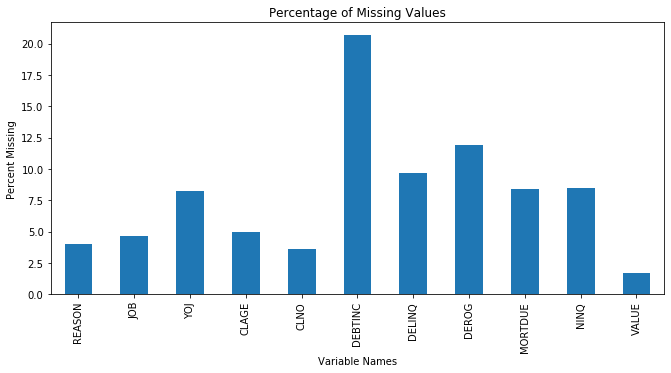

In [278]:
# Гистограмма по пропущенным значениям
tbl_forplot = pd.Series(list(data_card_df['PERCENT_MISSING']), index = list(data_card_df['_VARNAME_']))
ax = tbl_forplot.plot(
    kind = 'bar', 
    title = 'Percentage of Missing Values',
    figsize = (11, 5)
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

In [279]:
sess.dataPreprocess.transform(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0'
    },
    copyAllVars = True,
    outVarsNameGlobalPrefix = 'IM',
    requestPackages = [
        {
            'impute': {
                'method': 'MEAN'
            },
            'inputs': {
                'clage',
                'clno',
                'loan',
                'mortdue',
                'value',
                'delinq',
                'debtinc',
                'yoj',
                'ninq',
                'derog'
            }
        },
        {
            'impute': {
                'method': 'MODE'
            },
            'inputs': {
                'job',
                'reason'
            }
        }
    ],
    code = {
        'casout': {
            'name': 'impute_score_code',
            'replace': True
        }
    }
)

[TransInfo]

 Transformation Requests for HMEQ_TRAIN_VAL
 
   ActualName  NTransVars ImputeMethod
 0       _TR1          10         Mean
 1       _TR2           2         Mode

[VarTransInfo]

 Variable Transformation Information for HMEQ_TRAIN_VAL
 
    Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous  \
 0     CLAGE             IM    IM_CLAGE  3568    187               178.16403   
 1      CLNO             IM     IM_CLNO  3619    136                21.30506   
 2   DEBTINC             IM  IM_DEBTINC  2979    776                33.87233   
 3    DELINQ             IM   IM_DELINQ  3393    362                 0.44238   
 4     DEROG             IM    IM_DEROG  3309    446                 0.24630   
 5      LOAN             IM     IM_LOAN  3755      0             18639.38748   
 6   MORTDUE             IM  IM_MORTDUE  3440    315             73388.53549   
 7      NINQ             IM     IM_NINQ  3438    317                 1.16928   
 8     VALUE             IM    IM_VALUE  3693     62            101243.90481   
 9       YOJ             IM      IM_YOJ  3447    308                 8.91664   
 10      JOB             IM      IM_JOB  3581    174                     nan   
 11   REASON             IM   IM_REASON  3606    149                     nan   
 
    ImputedValueNominal  
 0                       
 1                       
 2                       
 3                       
 4                       
 5                       
 6                       
 7                       
 8                       
 9                       
 10               Other  
 11             DebtCon  

[NomVarInfo]

 Nominal Variable Information for HMEQ_TRAIN_VAL
 
   Variable          N     NMiss  NLevels
 0      JOB 3581.00000 174.00000  6.00000
 1   REASON 3606.00000 149.00000  2.00000

[OutputCasTables]

            casLib               Name  Rows  Columns  \
 0  SASWorkshopDay  impute_score_code     1       10   
 
                                   casTable  
 0  CASTable('impute_score_code', caslib...  

+ Elapsed: 0.0346s, user: 0.0243s, sys: 0.0131s, mem: 1.15mb

In [280]:
sess.CASTable('impute_score_code').fetch(to = 10)

,ModelName,DataStepSrc,DS2Src,FormatXML,FormatItemStore,VarXML,AStore,AStoreKey,ModelUUID,Notes
0,,_ngbys_ = 1;\n _igby_ = 0;\n ...,,,,,,,,


In [281]:
sess.dataStep.runCodeTable(
    table = 'hmeq_train_val',
    codeTable = 'impute_score_code',
    casout = 'hmeq_train_val_abt'
)
sess.dataStep.runCodeTable(
    table = 'hmeq_test',
    codeTable = 'impute_score_code',
    casout = 'hmeq_test_abt'
)

[InputCasTables]

            casLib       Name  Rows  Columns  \
 0  SASWorkshopDay  HMEQ_TEST   596       15   
 
                                   casTable  
 0  CASTable('HMEQ_TEST', caslib='SASWor...  

[OutputCasTables]

            casLib           Name  Rows  Columns  Append Promoted  \
 0  SASWorkshopDay  hmeq_test_abt   596       27     nan        N   
 
                                   casTable  
 0  CASTable('hmeq_test_abt', caslib='SA...  

+ Elapsed: 0.0644s, user: 0.092s, sys: 0.041s, mem: 8.64mb

In [282]:
raw_inputs = [
    v for v in sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']['Column']
    if v not in {'BAD', '_PartInd_', 'Customer_ID'}
]
raw_inputs_imp = [
    'IM_%s' % v
    for v in [
        'clage', 'clno', 'loan', 'mortdue',
        'value', 'delinq', 'debtinc', 'yoj',
        'ninq', 'derog', 'job', 'reason'
    ]
]

In [283]:
raw_inputs

['REASON',
 'LOAN',
 'customer_gender',
 'JOB',
 'YOJ',
 'CLAGE',
 'CLNO',
 'DEBTINC',
 'DELINQ',
 'DEROG',
 'MORTDUE',
 'NINQ',
 'VALUE']

## 2.7 Просмотр готовой таблицы для обучения моделей

In [284]:
sess.CASTable('hmeq_train_val_abt').head(10)

,BAD,REASON,LOAN,Customer_ID,customer_gender,JOB,YOJ,CLAGE,CLNO,DEBTINC,DELINQ,DEROG,MORTDUE,NINQ,VALUE,_PartInd_,IM_DEBTINC,IM_CLNO,IM_DEROG,IM_LOAN,IM_NINQ,IM_DELINQ,IM_YOJ,IM_VALUE,IM_MORTDUE,IM_CLAGE,IM_JOB,IM_REASON
0,1.00000,HomeImp,1100.00000,84673.00000,F,Other,10.50000,94.36667,9.00000,nan,0.00000,0.00000,25860.00000,1.00000,39025.00000,0.00000,33.87233,9.00000,0.00000,1100.00000,1.00000,0.00000,10.50000,39025.00000,25860.00000,94.36667,Other,HomeImp
1,1.00000,HomeImp,1300.00000,84676.00000,M,Other,7.00000,121.83333,14.00000,nan,2.00000,0.00000,70053.00000,0.00000,68400.00000,0.00000,33.87233,14.00000,0.00000,1300.00000,0.00000,2.00000,7.00000,68400.00000,70053.00000,121.83333,Other,HomeImp
2,1.00000,HomeImp,1500.00000,84682.00000,M,Other,4.00000,149.46667,10.00000,nan,0.00000,0.00000,13500.00000,1.00000,16700.00000,0.00000,33.87233,10.00000,0.00000,1500.00000,1.00000,0.00000,4.00000,16700.00000,13500.00000,149.46667,Other,HomeImp
3,0.00000,HomeImp,1700.00000,84690.00000,F,Office,3.00000,93.33333,14.00000,nan,0.00000,0.00000,97800.00000,0.00000,112000.00000,0.00000,33.87233,14.00000,0.00000,1700.00000,0.00000,0.00000,3.00000,112000.00000,97800.00000,93.33333,Office,HomeImp
4,1.00000,HomeImp,1700.00000,84693.00000,F,Other,9.00000,101.46600,8.00000,37.11361,0.00000,0.00000,30548.00000,1.00000,40320.00000,0.00000,37.11361,8.00000,0.00000,1700.00000,1.00000,0.00000,9.00000,40320.00000,30548.00000,101.46600,Other,HomeImp
5,1.00000,HomeImp,1800.00000,84695.00000,F,Other,5.00000,77.10000,17.00000,nan,2.00000,3.00000,48649.00000,1.00000,57037.00000,0.00000,33.87233,17.00000,3.00000,1800.00000,1.00000,2.00000,5.00000,57037.00000,48649.00000,77.10000,Other,HomeImp
6,1.00000,HomeImp,1800.00000,84701.00000,F,Other,11.00000,88.76603,8.00000,36.88489,0.00000,0.00000,28502.00000,0.00000,43034.00000,0.00000,36.88489,8.00000,0.00000,1800.00000,0.00000,0.00000,11.00000,43034.00000,28502.00000,88.76603,Other,HomeImp
7,1.00000,HomeImp,2000.00000,84722.00000,M,Sales,16.00000,115.80000,13.00000,nan,0.00000,0.00000,nan,0.00000,62250.00000,0.00000,33.87233,13.00000,0.00000,2000.00000,0.00000,0.00000,16.00000,62250.00000,73388.53549,115.80000,Sales,HomeImp
8,1.00000,HomeImp,2000.00000,84728.00000,M,Office,11.00000,122.53333,9.00000,nan,1.00000,0.00000,20627.00000,1.00000,29800.00000,0.00000,33.87233,9.00000,0.00000,2000.00000,1.00000,1.00000,11.00000,29800.00000,20627.00000,122.53333,Office,HomeImp
9,1.00000,HomeImp,2000.00000,84730.00000,F,Other,3.00000,86.06667,25.00000,nan,0.00000,0.00000,45000.00000,2.00000,55000.00000,0.00000,33.87233,25.00000,0.00000,2000.00000,2.00000,0.00000,3.00000,55000.00000,45000.00000,86.06667,Other,HomeImp


# 3.Обучение моделей

## 3.1 Random Forest

In [285]:
rf = sess.decisionTree.forestTrain(
    table={
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    nominals = ['bad'],
    target = 'bad',
    nTree = 20,
    nBins = 20,
    leafSize = 5,
    maxLevel = 21,
    crit = 'GAINRATIO',
    varImp = True,
    seed = 1234,
    OOB = True,
    vote = 'PROB',
    saveState = {
        'name': 'forest_ast',
        'replace': True
    },
    nthreads = 3
)

NOTE: 4324242 bytes were written to the table "forest_ast" in the caslib "SASWorkshopDay".


In [286]:
rf

,Descr,Value
0,Number of Trees,20.00000
1,Number of Selected Variables (M),4.00000
2,Random Number Seed,1234.00000
3,Bootstrap Percentage (%),63.21206
4,Number of Bins,20.00000
5,Number of Variables,13.00000
6,Confidence Level for Pruning,0.25000
7,Max Number of Tree Nodes,305.00000
8,Min Number of Tree Nodes,221.00000
9,Max Number of Branches,2.00000


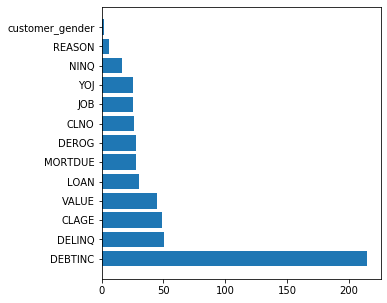

In [287]:
var_imp = rf['DTreeVarImpInfo']
plt.figure(figsize=(5, 5))
_ = plt.barh(
    y = var_imp.Variable,
    width = var_imp.Importance
)

## 3.2 Gradient Boosting

In [288]:
gb = sess.decisionTree.gbtreeTrain(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    validTable = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 1'
    },
    earlyStop = {
        'metric': 'logloss',
        'minimum': True,
        'stagnation': 5
    },
    inputs = raw_inputs,
    nominals = ['bad'],
    target = 'bad',
    seed = 1234,
    nTree = 100,
    learningRate = 0.1,
    nBins = 20,
    maxLevel = 3,
    varImp = True,
    saveState = {
        'name': 'gb_ast',
        'replace': True
    }
)

NOTE: 497935 bytes were written to the table "gb_ast" in the caslib "SASWorkshopDay".


## 3.3 Random Forest Autotune

In [289]:
rf = sess.autotune.tuneForest(
    trainOptions = {
        'table': {
            'name': 'hmeq_train_val_abt',
            'where': '_partind_ = 0'
        },
        'inputs': raw_inputs,
        'nominals': ['bad'],
        'target': 'bad',
        'nBins': 20,
        'nTree': 20,
        'leafSize': 5,
        'maxLevel': 21,
        'crit': 'GAINRATIO',
        'varImp': True,
        'seed': 1234,
        'OOB': True,
        'vote': 'PROB',
        'saveState': {
            'name': 'forest_auto_ast',
            'replace': True
        }
    },
    tunerOptions = {
        'searchMethod': 'GA',
        'popSize': 10,
        'objective': 'AUC',
        'maxIters': 3,
        'enableLocalSearch': False,
        'nFolds': 5
    },
    tuningParameters = [
        {
            'namePath': 'bootstrap',
            'initValue': 0.5,
            'lowerBound': 0.001,
            'upperBound': 1
        }
    ],
    useParameters = 'CUSTOM'
)

NOTE: Autotune is started for 'Forest' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXTIME=36000 (sec.).
NOTE: Autotune option SEED=1234.
NOTE: Autotune objective is 'Area Under Curve'.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             0.9153          3.28
                 1          10             0.9252         15.80
                 2          17             0.9252         28.18
                 3          22             0.9252         39.93
NOTE: 6655570 bytes were written to the table "forest_auto_ast" in the caslib "CASUSER(sasdemo)".
NOTE: Autotune time is 41.24 seconds.


## 3.4 Model Composer

### Байесовская оптимизация

$$
f(x) \sim N(\mu(x), \Sigma(x, x)) \quad EI(x) = E[\max(f(x) - f(\widehat{x^*}), 0) \mid I] \rightarrow \max\limits_x
$$

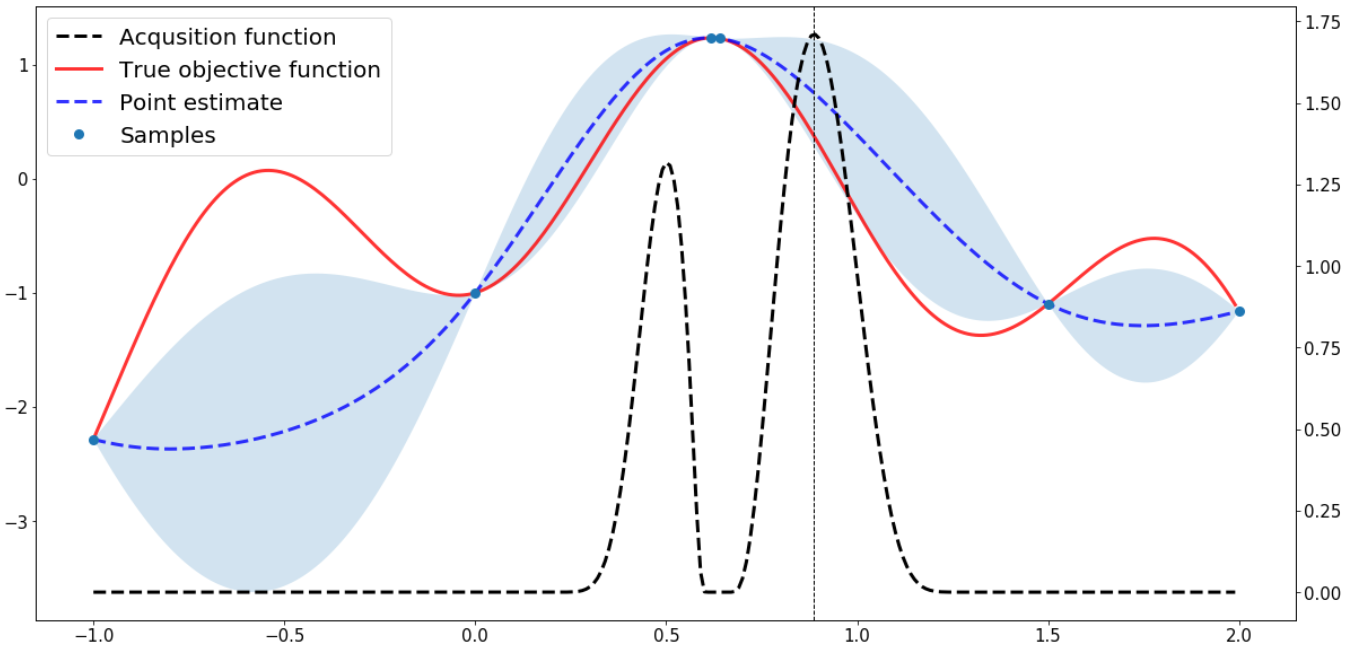

In [290]:
comp = sess.autotune.modelComposer(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    nRounds = 2,
    nEvalsPerRound = 10,
    acquisitionFunction = 'EI',
    policyOptions = {
        'policy': 'epsGreedy',
        'epsGreedyOptions': {
            'eps': 0.25
        }
    },
    inputs = raw_inputs,
    target = 'bad',
    tunerOptions = {
        'objective': 'AUC',
        'enableLocalSearch': False,
        'popSize': 5,
        'nFolds': 3
    },
    nominals = ['bad'],
    modelTypes = [
        {
            'modelType': 'gradboost',
            'tuningOptions': {
                'trainOptions': {
                    'saveState': {
                        'name': 'comp_gb_ast',
                        'replace': True
                    }
                }
            }
        },
        {
            'modelType': 'forest',
            'tuningOptions': {
                'trainOptions': {
                    'saveState': {
                        'name': 'comp_forest_ast',
                        'replace': True
                    }
                }
            }
        }
    ]
)

NOTE: Model Composer round: 1
NOTE: >> Allocation:
              5 - 1_GradBoost_Round1
              5 - 2_Forest_Round1
NOTE: Added action set 'autotune'.
NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=5.
NOTE: Autotune option MAXTIME=36000 (sec.).
NOTE: Autotune option SEED=1452933966.
NOTE: Autotune objective is 'Area Under Curve'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Added action set 'decisionTree'.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             0.8402          1.16
                 1           5             0.9632          6.53
NOTE: 2156226 bytes were written to the table "comp_gb_ast" in the caslib "CASUSER(sasdemo)".
NOT

In [291]:
comp['TuneAllBestModels']

,ModelID,Evaluation,AreaUnderCurve,EvaluationTime
0,1_GradBoost_Round2,8,0.96998,7.18516
1,1_GradBoost_Round2,1,0.96454,5.84305
2,1_GradBoost_Round2,5,0.96323,0.00199
3,1_GradBoost_Round2,0,0.96323,0.21344
4,1_GradBoost_Round2,7,0.95310,7.34380
5,2_Forest_Round2,5,0.94220,0.00111
6,2_Forest_Round2,0,0.94220,0.22090
7,1_GradBoost_Round2,9,0.93762,6.74562
8,2_Forest_Round2,4,0.93249,5.49294
9,2_Forest_Round2,2,0.92916,8.76301


In [292]:
if comp['TuneAllBestModels']['ModelID'][0].split('_')[2] == 'GradBoost':
    cmp_best = 'gb'
else:
    cmp_best = 'forest'
print(cmp_best)

forest


## 3.5 Сравнение моделей

In [293]:
# Функция для получения показателей качества модели
def assess_model(ast, table):
    sess.astore.score(
        table = table,
        rstore = ast,
        out = {
            'name': '__scored',
            'replace': True
        },
        copyVars = ['BAD']
    )
    return sess.percentile.assess(
        table = '__scored',
        inputs = [{'name': 'p_bad1'}],
        response = 'bad',
        event = '1',
        cutStep = 1 / len(sess.CASTable('__scored'))
    )

In [294]:
models = ['forest_ast', 'gb_ast', 'forest_auto_ast', 'comp_%s_ast' % cmp_best]
names = {
    'forest_ast': 'Forest',
    'gb_ast': 'Gradient Boosting',
    'forest_auto_ast': 'Forest Autotuned',
    'comp_%s_ast' % cmp_best: 'Model Composer'
}

In [295]:
assess_data = {
    a: assess_model(a, {'name': 'hmeq_train_val_abt', 'where': '_partind_ = 1'})
    for a in models
}

In [296]:
assess_data['forest_ast']['ROCInfo'].head(5)

,Variable,Event,CutOff,TP,FP,FN,TN,Sensitivity,Specificity,KS,KS2,F_HALF,FPR,ACC,FDR,F1,C,Gini,Gamma,Tau,MISCEVENT
0,P_BAD1,1,0.00000,319.00000,1290.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.23612,1.00000,0.19826,0.80174,0.33091,0.94464,0.88928,0.88953,0.28288,0.80174
1,P_BAD1,1,0.00062,319.00000,1268.00000,0.00000,22.00000,1.00000,0.01705,0.00000,0.01705,0.23924,0.98295,0.21193,0.79899,0.33473,0.94464,0.88928,0.88953,0.28288,0.78807
2,P_BAD1,1,0.00124,319.00000,1265.00000,0.00000,25.00000,1.00000,0.01938,0.00000,0.01938,0.23967,0.98062,0.21380,0.79861,0.33526,0.94464,0.88928,0.88953,0.28288,0.78620
3,P_BAD1,1,0.00186,319.00000,1249.00000,0.00000,41.00000,1.00000,0.03178,0.00000,0.03178,0.24200,0.96822,0.22374,0.79656,0.33810,0.94464,0.88928,0.88953,0.28288,0.77626
4,P_BAD1,1,0.00249,318.00000,1243.00000,1.00000,47.00000,0.99687,0.03643,0.00000,0.03330,0.24227,0.96357,0.22685,0.79628,0.33830,0.94464,0.88928,0.88953,0.28288,0.77315


In [297]:
for m in models:
    assess_data[m]['ROCInfo']['model'] = m
    assess_data[m]['ROCInfo']['model_name'] = names[m]
    assess_data[m]['LIFTInfo']['model'] = m
    assess_data[m]['LIFTInfo']['model_name'] = names[m]

In [298]:
roc_data = pd.concat(assess_data[m]['ROCInfo'] for m in models)
lift_data = pd.concat(assess_data[m]['LIFTInfo'] for m in models)

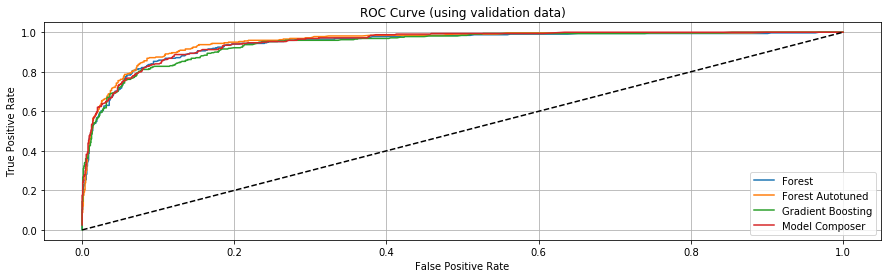

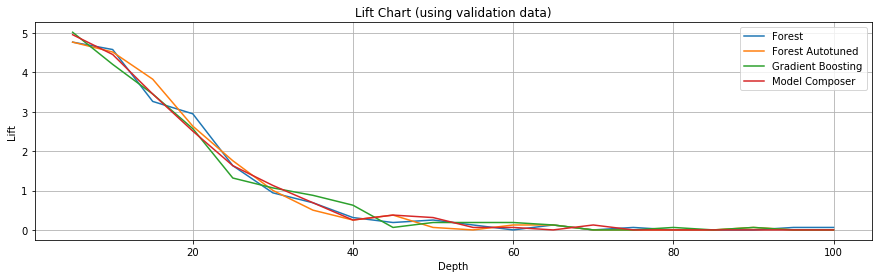

In [299]:
# Draw ROC charts 
plt.figure(figsize = (15, 4))
for key, grp in roc_data.groupby(['model_name']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc = 'best')
plt.title('ROC Curve (using validation data)')
plt.show()

# Draw lift charts
plt.figure(figsize = (15, 4))
for key, grp in lift_data.groupby(['model_name']):
    plt.plot(grp['Depth'], grp['Lift'], label = key)
plt.xlabel('Depth')
plt.ylabel('Lift')
plt.grid(True)
plt.legend(loc = 'best')
plt.title('Lift Chart (using validation data)')
plt.show()

In [300]:
aucs = roc_data.groupby(by = 'model')['C', 'model_name'] \
.max()\
.sort_values(by = 'C', ascending = False)\
.reset_index()
aucs

,model,C,model_name
0,forest_auto_ast,0.95359,Forest Autotuned
1,comp_forest_ast,0.94970,Model Composer
2,forest_ast,0.94464,Forest
3,gb_ast,0.94188,Gradient Boosting


In [301]:
champion_model = aucs.model[0]
print(champion_model)

forest_auto_ast


## 4 Интерпретация работы модели

## 4.1 Partial Dependence

In [302]:
r = sess.explainModel.partialDependence(
    analysisVariable = {
        'name': 'DEBTINC',
        'nBins': 25
    },
    inputs = raw_inputs,
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    output = {
        'casout':{
            'name': 'pd_table',
            'replace': True
        },
        'copyVars': 'ALL'
    },
    predictedTarget = 'P_BAD1',
    sampleSize = 2000,
    table = {

        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

NOTE: Starting the partialDependence action.
NOTE: Generating replicates.
NOTE: Finished generating replicates.
NOTE: The size of the replicates dataset is approximately 7.85655 MB. To reduce the size of the dataset, decrease the value of the NBINS, MAXLEVELS, or SAMPLESIZE parameter.


In [303]:
sess.CASTable('pd_table').columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,P_BAD1,Predicted: BAD=1,1,double,8,12,,0,0
1,P_BAD0,Predicted: BAD=0,2,double,8,12,,0,0
2,I_BAD,Into: BAD,3,char,32,32,,0,0
3,_WARN_,Warnings,4,char,4,4,,0,0
4,LOAN,Requested loan amount,5,double,8,12,,0,0
5,YOJ,Years at present job,6,double,8,12,,0,0
6,CLAGE,Age of oldest credit line in months,7,double,8,12,,0,0
7,CLNO,Number of credit lines,8,double,8,12,,0,0
8,DEBTINC,Debt-to-income ratio,9,double,8,12,,0,0
9,DELINQ,Number of delinquent credit lines,10,double,8,12,,0,0


In [304]:
sess.CASTable('pd_table').groupby(by = 'DEBTINC')['P_BAD1'].mean(
    casout = {
        'name': 'mean',
        'replace': True
    }
)
_ = sess.dataStep.runCode(code = '''
    data pd_plot;
        set mean;
        ci_lower = _Mean_ - 1.96 * _Std_;
        ci_upper = _Mean_ + 1.96 * _Std_;
        p_bad1 = _Mean_;
        keep debtinc ci_lower ci_upper p_bad1;
    run;
'''
)

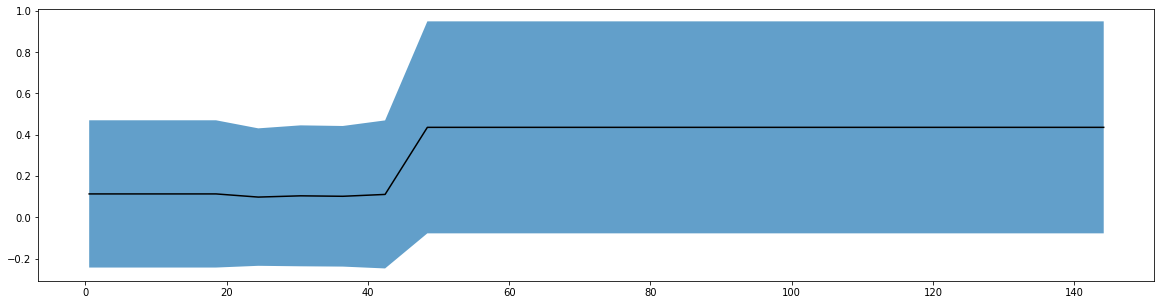

In [305]:
pd_plot = sess.CASTable('pd_plot').to_frame().sort_values(by = 'DEBTINC')
fig = plt.figure(figsize = (20, 5))
plt.fill_between(pd_plot.DEBTINC, pd_plot.ci_lower, pd_plot.ci_upper, alpha = 0.7)
_ = plt.plot(pd_plot.DEBTINC, pd_plot.p_bad1, color = 'black')

## 4.2 Individual Conditional Expectations

### 4.2.1 Option 1

In [306]:
ice_plot = sess.CASTable('pd_table').to_frame(fetchvars = ['Customer_ID', 'P_BAD1', 'DEBTINC'])

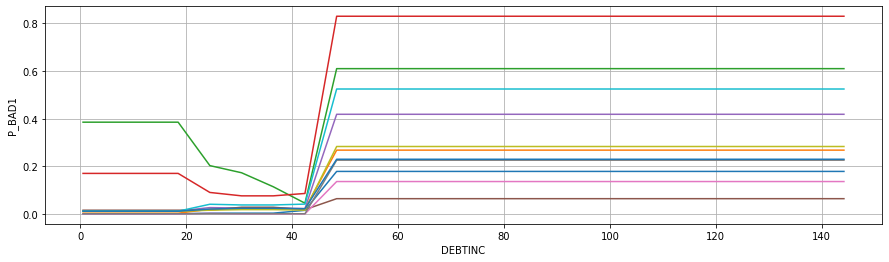

In [307]:
plt.figure(figsize = (15, 4))
for i, (key, grp) in enumerate(ice_plot.groupby(['Customer_ID'])):
    plt.plot(grp['DEBTINC'], grp['P_BAD1'])
    if i >= 10:
        break
plt.xlabel('DEBTINC')
plt.ylabel('P_BAD1')
plt.grid(True)

### 4.2.2 Option 2

In [308]:
obs = sess.CASTable('hmeq_train_val_abt').head(1)

In [309]:
obs_dict = {
    k: obs[k][0]
    for k in sess.CASTable('hmeq_train_val_abt').columns
    if k not in {'Customer_ID', 'BAD', '_PartInd_'}
}

In [310]:
sess.dataPreprocess.binning(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = ['DEBTINC'],
    nBinsArray = [50],
    casOutBinDetails = {
        'name': 'bins',
        'replace': True
    }
)
bins = sess.CASTable('bins').to_frame(fetchvars = ['_BinLowerBnd_', '_BinUpperBnd_'])
bins['mid'] = 0.5 * (bins['_BinLowerBnd_'] + bins['_BinUpperBnd_'])

In [311]:
sas_code = 'data ice_samples;'
for var_name, value in obs_dict.items():
    if var_name == 'DEBTINC':
        continue
    if type(value) == np.float64:
        sas_code += '\n\t%s = %f;' % (var_name, value)
    else:
        sas_code += '\n\t%s = "%s";' % (var_name, value)
for b in bins.mid:
    sas_code += '\n\tDEBTINC = %f;' % b
    sas_code += '\n\toutput;'
sas_code += '\nrun;'
print(sas_code)

data ice_samples;
	REASON = "HomeImp";
	LOAN = 1100.000000;
	customer_gender = "F";
	JOB = "Other";
	YOJ = 10.500000;
	CLAGE = 94.366667;
	CLNO = 9.000000;
	DELINQ = 0.000000;
	DEROG = 0.000000;
	MORTDUE = 25860.000000;
	NINQ = 1.000000;
	VALUE = 39025.000000;
	IM_DEBTINC = 33.872331;
	IM_CLNO = 9.000000;
	IM_DEROG = 0.000000;
	IM_LOAN = 1100.000000;
	IM_NINQ = 1.000000;
	IM_DELINQ = 0.000000;
	IM_YOJ = 10.500000;
	IM_VALUE = 39025.000000;
	IM_MORTDUE = 25860.000000;
	IM_CLAGE = 94.366667;
	IM_JOB = "Other";
	IM_REASON = "HomeImp";
	DEBTINC = 1.961144;
	output;
	DEBTINC = 4.834434;
	output;
	DEBTINC = 7.707724;
	output;
	DEBTINC = 10.581014;
	output;
	DEBTINC = 13.454304;
	output;
	DEBTINC = 16.327594;
	output;
	DEBTINC = 19.200884;
	output;
	DEBTINC = 22.074175;
	output;
	DEBTINC = 24.947465;
	output;
	DEBTINC = 27.820755;
	output;
	DEBTINC = 30.694045;
	output;
	DEBTINC = 33.567335;
	output;
	DEBTINC = 36.440625;
	output;
	DEBTINC = 39.313915;
	output;
	DEBTINC = 42.187205;
	output;


In [312]:
sess.dataStep.runcode(code = sas_code)

[InputCasTables]

 Empty DataFrame
 Columns: [casLib, Name, Rows, Columns, casTable]
 Index: []

[OutputCasTables]

            casLib         Name  Rows  Columns  Append Promoted  \
 0  SASWorkshopDay  ice_samples   600       25     nan        N   
 
                                   casTable  
 0  CASTable('ice_samples', caslib='SASW...  

+ Elapsed: 0.0444s, user: 0.0531s, sys: 0.0392s, mem: 8.99mb

In [313]:
sess.astore.score(
    table = 'ice_samples',
    rstore = champion_model,
    casOut = {
        'name': 'ice_plot',
        'replace': True
    },
    copyVars = ['DEBTINC']
)

[OutputCasTables]

            casLib      Name  Rows  Columns  \
 0  SASWorkshopDay  ice_plot   600        5   
 
                                   casTable  
 0  CASTable('ice_plot', caslib='SASWork...  

[Timing]

 Task Timing
 
                  Task  Seconds  Percent
 0   Loading the Store  0.00012  0.00044
 1  Creating the State  0.26040  0.96192
 2             Scoring  0.00967  0.03572
 3               Total  0.27071  1.00000

+ Elapsed: 0.276s, user: 0.27s, sys: 0.0182s, mem: 38.2mb

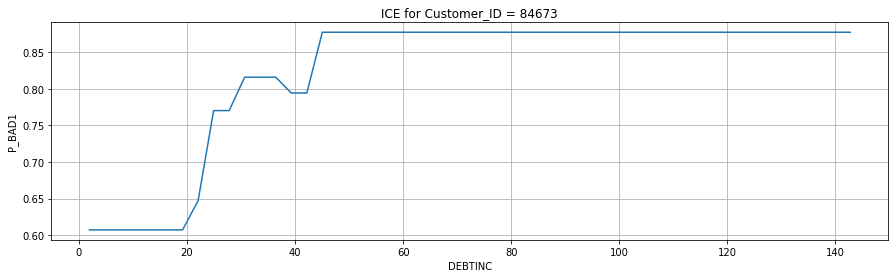

In [314]:
ice_plot = sess.CASTable('ice_plot').to_frame(fetchvars = ['DEBTINC', 'P_BAD1']).sort_values(by = 'DEBTINC')
plt.figure(figsize = (15, 4))
plt.plot(ice_plot['DEBTINC'], ice_plot['P_BAD1'])
plt.xlabel('DEBTINC')
plt.ylabel('P_BAD1')
plt.grid(True)
_ = plt.title('ICE for Customer_ID = %d' % obs.Customer_ID[0])

## 4.3 LIME

In [315]:
lime = sess.explainModel.linearExplainer(
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    preset = 'LIME',
    inputs = raw_inputs,
    dataGeneration = {
        'binaryEncoding': 'NONE',
        'sampleSize': 1000
    },
    predictedTarget = 'P_BAD1',
    query = {
        'name': 'hmeq_train_val_abt',
        'where': 'Customer_ID = %d' % obs.Customer_ID[0]
    },
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

NOTE: Starting the Linear Explainer action.
NOTE: The exponential kernel weight is automatically set to 2.5980762114.
NOTE: The mixed distance weight is automatically set to 1.
NOTE: Generating kernel weights.
NOTE: Kernel weights generated.


In [316]:
lime.keys()

odict_keys(['ExplainerInfo', 'ParameterEstimates', 'ExplainerFidelity'])

In [317]:
lime['ParameterEstimates']

,Variable,REASON,customer_gender,JOB,Estimate,QueryValue
0,Intercept,,,,0.08194,nan
1,REASON,HomeImp,,,0.00000,1.00000
2,LOAN,,,,-0.00000,1100.00000
3,customer_gender,,F,,0.00000,1.00000
4,JOB,,,Office,-0.04782,0.00000
5,JOB,,,ProfExe,0.05256,0.00000
6,JOB,,,Other,0.00000,1.00000
7,YOJ,,,,0.00000,10.50000
8,CLAGE,,,,0.00000,94.36667
9,CLNO,,,,-0.00661,9.00000


In [318]:
ests = lime['ParameterEstimates'].copy()

cinfo = sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']

raw_inputs_nominals = list(cinfo.loc[cinfo.Type == 'char', 'Column'])

selected_nominals = \
{v for v in lime['ParameterEstimates'].Variable}\
.intersection(
    {
        v for v in raw_inputs_nominals
    }
)

for i in range(len(ests)):
    if ests.Variable[i] in selected_nominals:
        if ests.dtypes[ests.Variable[i]] == np.float64:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= %d)' % ests.loc[i, ests.loc[i, 'Variable']]
        else:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= "%s")' % ests.loc[i, ests.loc[i, 'Variable']]

ests = ests[['Variable', 'Estimate', 'QueryValue']].copy()

ests['AbsEstimate'] = ests.Estimate.apply(lambda x: abs(x))
ests.sort_values(by = 'AbsEstimate', inplace = True, ascending = False)

In [319]:
ests

,Variable,Estimate,QueryValue,AbsEstimate
0,Intercept,0.08194,nan,0.08194
5,"JOB (= ""ProfExe"")",0.05256,0.00000,0.05256
4,"JOB (= ""Office"")",-0.04782,0.00000,0.04782
11,DELINQ,0.03532,0.00000,0.03532
10,DEBTINC,0.01167,nan,0.01167
14,NINQ,-0.00933,1.00000,0.00933
9,CLNO,-0.00661,9.00000,0.00661
2,LOAN,-0.00000,1100.00000,0.00000
15,VALUE,-0.00000,39025.00000,0.00000
1,"REASON (= ""HomeImp"")",0.00000,1.00000,0.00000


## 4.4 Kernel SHAP

In [320]:
shap = sess.explainModel.linearExplainer(
    modelTable = champion_model,
    modelTableType = 'ASTORE',
    preset = 'KERNELSHAP',
    inputs = raw_inputs,
    dataGeneration = {
        'binaryEncoding': 'NONE',
        'sampleSize': 1000
    },
    predictedTarget = 'P_BAD1',
    query = {
        'name': 'hmeq_train_val_abt',
        'where': 'Customer_ID = %d' % obs.Customer_ID[0]
    },
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    seed = 1234
)

NOTE: Starting the Linear Explainer action.
NOTE: Generating kernel weights.
NOTE: Kernel weights generated.


In [321]:
shap.keys()

odict_keys(['ExplainerInfo', 'ParameterEstimates', 'ExplainerFidelity'])

In [322]:
shap['ParameterEstimates']

,Variable,REASON,customer_gender,JOB,Estimate,QueryValue
0,Intercept,,,,-0.00498,nan
1,REASON,DebtCon,,,-0.01011,0.00000
2,REASON,HomeImp,,,0.00000,1.00000
3,LOAN,,,,-0.00000,1100.00000
4,customer_gender,,M,,-0.00321,0.00000
5,customer_gender,,U,,-0.00441,0.00000
6,customer_gender,,F,,0.00000,0.00000
7,JOB,,,Mgr,0.01404,0.00000
8,JOB,,,Office,0.02818,0.00000
9,JOB,,,ProfExe,0.00207,0.00000


In [323]:
ests = shap['ParameterEstimates'].copy()

cinfo = sess.CASTable('hmeq_train_val').columninfo()['ColumnInfo']

raw_inputs_nominals = list(cinfo.loc[cinfo.Type == 'char', 'Column'])

selected_nominals = \
{v for v in lime['ParameterEstimates'].Variable}\
.intersection(
    {
        v for v in raw_inputs_nominals
    }
)

for i in range(len(ests)):
    if ests.Variable[i] in selected_nominals:
        if ests.dtypes[ests.Variable[i]] == np.float64:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= %d)' % ests.loc[i, ests.loc[i, 'Variable']]
        else:
            ests.loc[i, 'Variable'] = ests.loc[i, 'Variable'] + ' (= "%s")' % ests.loc[i, ests.loc[i, 'Variable']]

ests = ests[['Variable', 'Estimate']].copy()

ests['AbsEstimate'] = ests.Estimate.apply(lambda x: abs(x))
ests.sort_values(by = 'AbsEstimate', inplace = True, ascending = False)

In [324]:
ests

,Variable,Estimate,AbsEstimate
10,"JOB (= ""Sales"")",0.21293,0.21293
17,DELINQ,0.11504,0.11504
18,DEROG,0.07389,0.07389
11,"JOB (= ""Self"")",0.05749,0.05749
8,"JOB (= ""Office"")",0.02818,0.02818
7,"JOB (= ""Mgr"")",0.01404,0.01404
1,"REASON (= ""DebtCon"")",-0.01011,0.01011
20,NINQ,0.00903,0.00903
15,CLNO,-0.00618,0.00618
16,DEBTINC,0.00615,0.00615


# 5. Bonus track: Запуск автоматического конвейера разработки модели SAS AutoML

## 5.1 Оценка показателей качества данных

In [325]:
sess.dataSciencePilot.exploreData(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0' # Train partition
    },
    inputs = raw_inputs,
    casOut = {
        'name': 'explore_data',
        'replace': True
    }
)
sess.CASTable('explore_data').head(1000)

,Variable,VarType,MissingRated,CardinalityRated,EntropyRated,IQVRated,CVRated,SkewnessRated,KurtosisRated,OutlierRated,N,NMiss,MissRate,Cardinality,CardinalityRatio,Shannon,Gini,VariationRatio,Top1Top2FreqRatio,Top1Bottom1FreqRatio,Top1,Top2,Top3,Bottom1,Bottom2,Bottom3,Min,Max,Mean,Median,Std,IQR,MomentCVPer,RobustCVPer,MomentSkewness,RobustSkewness,MomentKurtosis,RobustKurtosis,LowerOutlierMomentPer,UpperOutlierMomentPer,LowerOutlierRobustPer,UpperOutlierRobustPer
0,REASON,character-nominal,1.00000,1.00000,3.00000,nan,nan,nan,nan,nan,3606.00000,149.00000,3.96804,2.00000,0.00055,0.88901,0.85013,0.30643,2.26335,2.26335,2501.00000,1105.00000,nan,1105.00000,2501.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,customer_gender,character-nominal,1.00000,1.00000,3.00000,3.00000,nan,nan,nan,nan,3755.00000,0.00000,0.00000,3.00000,0.00080,0.68686,0.76949,0.50120,1.02238,37.46000,1873.00000,1832.00000,50.00000,50.00000,1832.00000,1873.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,JOB,character-nominal,1.00000,1.00000,3.00000,3.00000,nan,nan,nan,nan,3581.00000,174.00000,4.63382,6.00000,0.00168,0.80614,0.86559,0.57582,1.85924,24.50000,1519.00000,817.00000,586.00000,62.00000,107.00000,490.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,LOAN,numeric-nominal,1.00000,3.00000,nan,nan,nan,nan,nan,nan,3755.00000,0.00000,0.00000,490.00000,0.13049,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,YOJ,interval,2.00000,nan,nan,nan,3.00000,1.00000,1.00000,2.00000,3447.00000,308.00000,8.20240,87.00000,0.02524,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,41.00000,8.91664,7.00000,7.47319,10.00000,83.81171,142.85714,0.95804,0.98399,0.30902,-0.12931,0.00000,2.00174,0.00000,0.02901
5,CLAGE,interval,1.00000,nan,nan,nan,3.00000,1.00000,2.00000,2.00000,3568.00000,187.00000,4.98003,3506.00000,0.98262,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000,1154.63333,178.16403,171.20975,85.15669,117.00742,47.79679,68.34156,1.19270,0.31101,6.06536,0.03472,0.00000,1.14910,0.00000,0.64462
6,CLNO,numeric-nominal,1.00000,2.00000,3.00000,3.00000,nan,nan,nan,nan,3619.00000,136.00000,3.62184,62.00000,0.01713,0.88584,0.98443,0.94059,1.09137,215.00000,215.00000,197.00000,164.00000,1.00000,1.00000,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,DEBTINC,interval,2.00000,nan,nan,nan,3.00000,1.00000,3.00000,2.00000,2979.00000,776.00000,20.66578,2979.00000,1.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.52450,144.18900,33.87233,34.88554,8.07717,9.70641,23.84591,27.82359,1.78890,-0.52934,28.05968,0.45774,0.97348,0.70493,0.50352,1.27560
8,DELINQ,numeric-nominal,2.00000,1.00000,2.00000,1.00000,nan,nan,nan,nan,3393.00000,362.00000,9.64048,12.00000,0.00354,0.33332,0.40674,0.21898,6.54321,2650.00000,2650.00000,405.00000,158.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,DEROG,numeric-nominal,2.00000,1.00000,2.00000,1.00000,nan,nan,nan,nan,3309.00000,446.00000,11.87750,11.00000,0.00332,0.23553,0.27126,0.13660,10.35145,2857.00000,2857.00000,276.00000,94.00000,1.00000,1.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


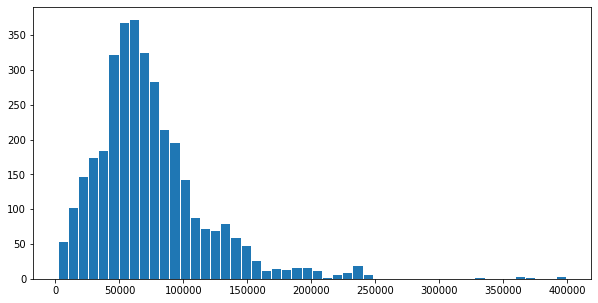

In [326]:
r = sess.dataPreprocess.binning(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = ['MORTDUE'],
    nBinsArray = [50]
)
bins = r['BinDetails']
bins['mid'] = 0.5 * (bins.BinLowerBnd + bins.BinUpperBnd)

plt.figure(figsize = (10, 5))
_ = plt.bar(x = bins.mid, height = bins.NInBin, width = bins.BinWidth[0] * 0.9)

## 5.2 Оценка показателей зависимости переменных

In [327]:
sess.dataSciencePilot.exploreCorrelation(
    table = {
        'name': 'hmeq_train_val',
        'where': '_partind_ = 0' # Train partition
    },
    inputs = raw_inputs,
    stats = {
        'intervalInterval': {'MI', 'SU'},
        'nominalInterval': {'MI', 'SU'},
        'nominalNominal': {'MI', 'SU'}
    },
    casOut = {
        'name': 'explore_correlation',
        'replace': True
    }
)
sess.CASTable('explore_correlation').head(1000).sort_values(by = 'SU', ascending = False)

,FirstVariable,SecondVariable,Type,MI,SU
60,VALUE,MORTDUE,_ii_11,1.53398,0.32671
65,VALUE,CLNO,_ii_7,0.35592,0.07710
42,MORTDUE,CLNO,_ii_7,0.34275,0.07441
62,VALUE,LOAN,_ii_4,0.35057,0.07374
7,CLNO,CLAGE,_ii_6,0.33888,0.07345
39,MORTDUE,LOAN,_ii_4,0.31489,0.06625
47,MORTDUE,JOB,_ni_3,0.28388,0.06312
41,MORTDUE,CLAGE,_ii_6,0.29199,0.06214
70,VALUE,JOB,_ni_3,0.27608,0.06152
14,DEBTINC,CLNO,_ii_7,0.27765,0.06019


### 5.2.1 Проверка зависимости переменных VALUE и MORTDUE

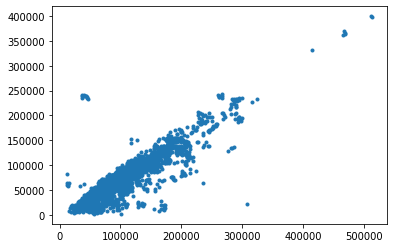

In [328]:
df = sess.CASTable('hmeq_train_val_abt').query('_partind_ = 0').to_frame(fetchvars = ['VALUE', 'MORTDUE'])
_ = plt.plot(df.VALUE, df.MORTDUE, 'o', markersize = 3)

### 5.2.2 Проверка зависимости переменных VALUE и CLNO

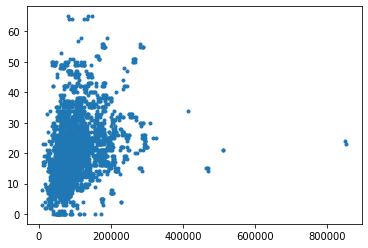

In [329]:
df = sess.CASTable('hmeq_train_val_abt').query('_partind_ = 0').to_frame(fetchvars = ['VALUE', 'CLNO'])
_ = plt.plot(df.VALUE, df.CLNO, 'o', markersize = 3)

## 5.3 Подбор преобразований для каждого признака (Feature Engineering)

In [330]:
_ = sess.dataSciencePilot.featureMachine(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    target = 'BAD',
    transformationPolicy = {
        'missing': True,
        'cardinality': True,
        'entropy': True,
        'iqv': True,
        'skewness': True,
        'kurtosis': True,
        'outlier': True
    },
    transformationOut = {
        'name': 'trans_out',
        'replace': True
    },
    featureOut = {
        'name': 'feature_list',
        'replace': True
    },
    saveState = {
        'name': 'features_ast',
        'replace': True
    }
)

In [331]:
sess.CASTable('feature_list').head(100)

,FeatureId,Name,IsNominal,FTGPipelineId,NInputs,InputVar1,InputVar2,InputVar3,Label
0,1.00000,cpy_int_med_imp_CLAGE,0.00000,32.00000,1.00000,CLAGE,,,CLAGE: Low missing rate - median imp...
1,2.00000,nhoks_nloks_dtree_10_CLAGE,1.00000,31.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
2,3.00000,nhoks_nloks_dtree_5_CLAGE,1.00000,30.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
3,4.00000,nhoks_nloks_log_CLAGE,0.00000,26.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
4,5.00000,nhoks_nloks_pow_n0_5_CLAGE,0.00000,25.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
5,6.00000,nhoks_nloks_pow_n1_CLAGE,0.00000,24.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
6,7.00000,nhoks_nloks_pow_n2_CLAGE,0.00000,23.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
7,8.00000,nhoks_nloks_pow_p0_5_CLAGE,0.00000,27.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
8,9.00000,nhoks_nloks_pow_p1_CLAGE,0.00000,28.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."
9,10.00000,nhoks_nloks_pow_p2_CLAGE,0.00000,29.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ..."


In [332]:
fm_nominals = [v for v in sess.CASTable('feature_list').query('IsNominal = 1')['Name']]
fm_intervals = [v for v in sess.CASTable('feature_list').query('IsNominal = 0')['Name']]

In [333]:
_ = sess.astore.score(
    table = 'hmeq_train_val_abt',
    rstore = 'features_ast',
    out = {
        'name': 'hmeq_train_val_abt_fm',
        'replace': True
    },
    copyVars = ['BAD', '_PartInd_', 'Customer_ID'] + raw_inputs
)

## 5.4 Анализ и отбор признаков

In [334]:
sess.dataSciencePilot.screenVariables(
    table = {
        'name': 'hmeq_train_val_abt_fm',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs + fm_intervals + fm_nominals,
    target = 'bad',
    nominals = ['bad'] + fm_nominals,
    screenPolicy = {
        'redundant': 0.8
    },
    casOut = {
        'name': 'screen_variables',
        'replace': True
    }
)
sess.CASTable('screen_variables').head(100)

,Variable,Recommendation,Reason
0,REASON,keep,passed all screening tests
1,customer_gender,remove,low target mutual information
2,JOB,remove,redundant
3,nhoks_nloks_dtree_10_CLAGE,remove,redundant
4,nhoks_nloks_dtree_5_CLAGE,keep,passed all screening tests
5,hk_dtree_disct10_DEBTINC,keep,passed all screening tests
6,hk_dtree_disct5_DEBTINC,keep,passed all screening tests
7,miss_ind_DEBTINC,keep,passed all screening tests
8,ho_dtree_disct10_MORTDUE,remove,redundant
9,ho_dtree_disct5_MORTDUE,keep,passed all screening tests


In [335]:
vars_to_exclude = set(
    sess.CASTable('screen_variables')\
    .query('Recommendation = "remove"')\
    .to_frame(fetchvars = ['Variable']).Variable
)
exclude = lambda x: list(set(x).difference(vars_to_exclude))
raw_inputs_sc = exclude(raw_inputs)
fm_intervals_sc = exclude(fm_intervals)
fm_nominals_sc = exclude(fm_nominals)
for i, v in enumerate(raw_inputs_sc + fm_intervals_sc + fm_nominals_sc):
    print('%d\t%s' % (i, v))

0	DELINQ
1	DEROG
2	NINQ
3	REASON
4	LOAN
5	CLNO
6	hc_tar_frq_rat_LOAN
7	nhoks_nloks_pow_n0_5_YOJ
8	hc_lbl_cnt_LOAN
9	ho_winsor_VALUE
10	cpy_int_med_imp_DEBTINC
11	nhoks_nloks_pow_n2_CLAGE
12	ho_winsor_MORTDUE
13	nhoks_nloks_dtree_5_YOJ
14	ho_dtree_disct10_VALUE
15	ho_quan_disct5_MORTDUE
16	nhoks_nloks_dtree_5_CLAGE
17	miss_ind_NINQ
18	ho_quan_disct5_VALUE
19	miss_ind_YOJ
20	hk_dtree_disct5_DEBTINC
21	miss_ind_DEBTINC
22	cpy_nom_miss_lev_lab_JOB
23	hk_dtree_disct10_DEBTINC
24	cpy_nom_miss_lev_lab_CLNO
25	ho_dtree_disct5_VALUE
26	ho_dtree_disct5_MORTDUE


## 5.5 Запуск всех шагов SAS AutoML в одном action

In [336]:
r = sess.dataSciencePilot.dsAutoMl(
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 0'
    },
    inputs = raw_inputs,
    target = 'bad',
    modelTypes = [
        'forest',
        'gradboost'
    ],
    kFolds = 3,
    objective = 'AUC',
    sampleSize = 4, # maximum number of pipelines to sample
    transformationPolicy = {
        'missing': True,
        'cardinality': True,
        'entropy': True,
        'iqv': True,
        'skewness': True,
        'kurtosis': True,
        'outlier': True
    },
    transformationOut = {
        'name': 'transformation',
        'replace': True
    },
    featureOut = {
        'name': 'feature_list',
        'replace': True
    },
    pipelineOut = {
        'name': 'pipeline',
        'replace': True
    },
    saveState = {
        'replace': True,
        'modelNamePrefix': 'dsaml',
        'topK': 2
    },
    seed = 1234
)

NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'decisionTree'.
NOTE: 8948109 bytes were written to the table "dsaml_gradBoost_1" in the caslib "CASUSER(sasdemo)".
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'decisionTree'.
NOTE: 9399689 bytes were written to the table "dsaml_gradBoost_2" in the caslib "CASUSER(sasdemo)".


In [337]:
sess.CASTable('feature_list').head(100)

,FeatureId,Name,IsNominal,FTGPipelineId,NInputs,InputVar1,InputVar2,InputVar3,Label,RankCrit,BestTransRank,GlobalIntervalRank,GlobalNominalRank,GlobalRank,IsGenerated
0,1.00000,cpy_int_med_imp_CLAGE,0.00000,31.00000,1.00000,CLAGE,,,CLAGE: Low missing rate - median imp...,0.01615,4.00000,11.00000,nan,23.00000,0.00000
1,2.00000,nhoks_nloks_dtree_10_CLAGE,1.00000,30.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01531,2.00000,nan,13.00000,25.00000,1.00000
2,3.00000,nhoks_nloks_dtree_5_CLAGE,1.00000,29.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.02047,1.00000,nan,12.00000,19.00000,1.00000
3,4.00000,nhoks_nloks_log_CLAGE,0.00000,25.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01797,2.00000,9.00000,nan,21.00000,1.00000
4,5.00000,nhoks_nloks_pow_n0_5_CLAGE,0.00000,24.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.02120,1.00000,7.00000,nan,17.00000,1.00000
5,6.00000,nhoks_nloks_pow_n1_CLAGE,0.00000,23.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01468,7.00000,16.00000,nan,29.00000,0.00000
6,7.00000,nhoks_nloks_pow_n2_CLAGE,0.00000,22.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.00386,8.00000,30.00000,nan,53.00000,0.00000
7,8.00000,nhoks_nloks_pow_p0_5_CLAGE,0.00000,26.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01515,6.00000,14.00000,nan,27.00000,0.00000
8,9.00000,nhoks_nloks_pow_p1_CLAGE,0.00000,27.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01615,4.00000,11.00000,nan,23.00000,0.00000
9,10.00000,nhoks_nloks_pow_p2_CLAGE,0.00000,28.00000,1.00000,CLAGE,,,"CLAGE: Not high (outlier, kurtosis, ...",0.01682,3.00000,10.00000,nan,22.00000,0.00000


In [338]:
df = sess.tableInfo()['TableInfo']
df.loc[df['Name'].apply(lambda s: s.startswith('DSAML_')) == 1, ['Name']]

,Name
30,DSAML_FM_
33,DSAML_GRADBOOST_1
34,DSAML_GRADBOOST_2


### Short list лучших пайплайнов AutoML

In [339]:
sess.CASTable('pipeline').head(100)

,PipelineId,ModelType,MLType,Objective,ObjectiveType,Target,NFeatures,Feat1Id,Feat1IsNom,Feat2Id,Feat2IsNom,Feat3Id,Feat3IsNom,Feat4Id,Feat4IsNom,Feat5Id,Feat5IsNom,Feat6Id,Feat6IsNom,Feat7Id,Feat7IsNom,Feat8Id,Feat8IsNom,Feat9Id,Feat9IsNom,Feat10Id,Feat10IsNom,Feat11Id,Feat11IsNom,Feat12Id,Feat12IsNom
0,2.00000,binary classification,gradBoost,0.99732,AUC,BAD,12.00000,45.00000,1.00000,50.00000,1.00000,19.00000,1.00000,58.00000,0.00000,59.00000,1.00000,3.00000,1.00000,44.00000,1.00000,29.00000,1.00000,36.00000,1.00000,64.00000,1.00000,22.00000,1.00000,66.00000,1.00000
1,4.00000,binary classification,gradBoost,0.97240,AUC,BAD,10.00000,45.00000,1.00000,53.00000,1.00000,13.00000,1.00000,58.00000,0.00000,62.00000,1.00000,4.00000,0.00000,44.00000,1.00000,29.00000,1.00000,40.00000,0.00000,65.00000,1.00000,nan,nan,nan,nan
2,3.00000,binary classification,forest,0.93795,AUC,BAD,10.00000,45.00000,1.00000,53.00000,1.00000,13.00000,1.00000,58.00000,0.00000,62.00000,1.00000,4.00000,0.00000,44.00000,1.00000,29.00000,1.00000,40.00000,0.00000,65.00000,1.00000,nan,nan,nan,nan
3,1.00000,binary classification,forest,0.92448,AUC,BAD,12.00000,45.00000,1.00000,50.00000,1.00000,19.00000,1.00000,58.00000,0.00000,59.00000,1.00000,3.00000,1.00000,44.00000,1.00000,29.00000,1.00000,36.00000,1.00000,64.00000,1.00000,22.00000,1.00000,66.00000,1.00000


In [340]:
best_pipeline = 'dsaml_' + sess.CASTable('pipeline') \
    .to_frame(fetchvars = ['MLType', 'Objective']) \
    .sort_values(by = 'Objective', ascending = False)['MLType'][0] \
    + '_1'
print(best_pipeline)

dsaml_gradBoost_1


# 6. Оценка точности готовой модели

## 6.1 Генерация признаков с помощью Feature Machine и запуск скоринга

In [341]:
sess.astore.score(
    rstore = 'DSAML_FM_',
    table = {
        'name': 'hmeq_train_val_abt',
        'where': '_partind_ = 1'
    },
    casOut = {
        'name': 'tmp',
        'replace': True
    },
    copyVars = ['bad']
)
_ = sess.astore.score(
    rstore = best_pipeline,
    table = 'tmp',
    casOut = {
        'name': 'dsaml_scored',
        'replace': True
    },
    copyVars = ['bad']
)

## 6.2 Расчет метрики точности полученного алгоритма

In [342]:
ad = sess.percentile.assess(
    table = 'dsaml_scored',
    inputs = [{'name': 'p_bad1'}],
    response = 'bad',
    event = '1',
    cutStep = 1 / len(sess.CASTable('dsaml_scored'))
)
print('AUC ROC for the best pipeline = %f' % ad['ROCInfo']['C'][0])

AUC ROC for the best pipeline = 0.941859


# 7. Регистрация модели в репозитории SAS Model Manager

После создания, модель регистрируется во встроенном репозитории платформы SAS Viya - SAS Model Manager, который отвечает за дальнейшее управление ее жизненным циклом, в том числе за интеграцию модели в различные среды применения, ее валидацию и оценку качества работы на этапе эксплуатации

In [363]:
from sasctl import register_model, Session

In [ ]:
with Session(hostname=cashost, username=casuser, password=password, verify_ssl=False):
    model = register_model(astore, 'RF forest Ast', 'Workshop Demo Project', force=True)